## Functional interpretation
Functional interpretation of differential splicing.

1) Function of affected genes
* ORA finds
    * Splicing factors: 
* Argument: aberrant splicing primarily hits 
2) Impact on ORF
* Affects 5'/3' UTR
    * no effect
    * alternative start (inframe)
    * novel uORF (might trigger NMD)
* in frame
    * additional AA
    * removed AA
* frame shift
    * NMD
    * alternative C terminus
* introduction of novel start (in frame)
    * alternative N terminus
* introduction of novel stop
    * mostly NMD
    * some alternative C terminus
* other
    * e.g. different open reading frame
* complex:
    * several ASE involved
* specifically look for poison exons
3) Impact on domains
4) disrupts isoform distribution (e.g. via NMD)
    * DIE test with setA vs setB - bipartite correspondence

In [1]:
import logging
import os
import pandas as pd
import numpy as np
from glob import glob
from isotools._utils import pairwise,has_overlap


from tqdm import tqdm
import matplotlib.pyplot as plt
import pathlib
from  isotools import Transcriptome
import isotools
logger=logging.getLogger('isotools')
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)
logger.info(f'This is isotools version {isotools.__version__}')


INFO:This is isotools version 0.3.4


In [2]:
path='/project/42/pacbio/golong'
date='2022_12'
project='golong_all'
out_path=f'{path}/06-isotools/{project}/results_{date}'
table_path=f'{out_path}/04_differential_splicing/tables'
plot_path=f'{out_path}/04_differential_splicing/plots'
pathlib.Path(plot_path).mkdir(parents=True, exist_ok=True)
pathlib.Path(table_path).mkdir(parents=True, exist_ok=True)

ref_fn=f'{path}/../references/gencode/gencode.v36.chr_patch_hapl_scaff.annotation_sorted'
genome_fn=f'{path}/../references/gencode/GRCh38.p13.genome.fa'

In [3]:
# set plot parameters
plt.rcParams['axes.unicode_minus']=False
plt.rcParams["font.size"]=8
plt.rcParams["font.family"]='sans-serif'#"Times New Roman"
plt.rcParams['figure.dpi']=200


## Load isoseq data

In [4]:

isoseq=Transcriptome.load(f'{out_path}/01_transcriptome/golong_all_{date}_isotools_sparse_domains_pfam.pkl')


INFO:loading transcriptome from /project/42/pacbio/golong/06-isotools/golong_all/results_2022_12/01_transcriptome/golong_all_2022_12_isotools_sparse_domains_pfam.pkl


In [5]:
# define group and sample colors

sample_tab=pd.read_csv(f'{out_path}/01_transcriptome/{project}_{date}_samples.csv').drop('Unnamed: 0', axis=1)

samples=list(sample_tab.name)
isoseq_groups={grp:[k for k,v in sample_tab.set_index('name')['group'].items() if v==grp] for grp in list(sample_tab.group.drop_duplicates())}
groups={k:v for k,v in isoseq_groups.items() if k[:3] in ['CLL', 'MDS']}
group_num={grp:i for i,grp in enumerate(['K562_mut','K562_wt','Nalm6_mut', 'Nalm6_wt','CLL_mut','CLL_wt', 'MDS_mut', 'MDS_wt','B-cell'])}

groups['CL_wt']=[sa for gr in ['K562_wt', 'Nalm6_wt'] for sa in isoseq_groups[gr]]
groups['CL_mut']=[sa for gr in ['K562_mut', 'Nalm6_mut'] for sa in isoseq_groups[gr]]
groups['B-cell']=isoseq_groups['B-cell']
group_idx={gn:[i for i,sa in enumerate(isoseq.samples) if sa in grp] for gn,grp in groups.items()}

group_dict={sa:gn for gn,sa_list in groups.items() for sa in sa_list}
#groups['GM12878_ENCODE']=isoseq_groups['GM12878']
group_colors={'CLL_mut':'#B2182B', 'CLL_wt':'#2166AC', 'MDS_mut':'#EF8A62', 'MDS_wt':'#67A9CF','CL_mut':'#FDDBC7' ,'CL_wt':'#D1E5F0','B-cell':'#543005','other':'#018571'}
group_colors['all_mut']=group_colors['MDS_mut']
group_colors['all_wt']=group_colors['MDS_wt']
group_colors['reference']=group_colors['other']

mut_samples=[sa for gn, grp in groups.items() if 'mut' in gn for sa in grp]

sample_colors={sa:group_colors[k] for sa in samples for k,v in groups.items() if sa in v }
sample_colors={sa:sample_colors.get(sa,'#003C30') for sa in samples}
sample_colors['reference']=group_colors['other']

groups_CL={k:v for k,v in groups.items() if k[:3] in ['CL_', 'GM1']}
groups_CLL={k:v for k,v in groups.items() if k in ['CLL_wt', 'CLL_mut', 'B-cell']}
groups_MDS={k:v for k,v in groups.items() if k in ['MDS_wt', 'MDS_mut', 'B-cell']}

group_same_colors={k:group_colors["all_"+k.split("_")[1]] for k in group_colors if 'wt' in k or 'mut' in k}
group_same_colors['B-cell']=group_colors['B-cell']


group_colors={'CLL_mut':'#B2182B', 'CLL_wt':'#2166AC', 'MDS_mut':'#EF8A62', 'MDS_wt':'#67A9CF','CL_mut':'#FDDBC7' ,'CL_wt':'#D1E5F0','B-cell':'#543005','GM12878_ENCODE':'#A6611A', 'other':'#018571'}
group_colors['all_mut']=group_colors['MDS_mut']
group_colors['all_wt']=group_colors['MDS_wt']
group_colors['reference']=group_colors['other']


## differential splicing
load the results

In [6]:
gr=groups
gr.update({'all_mut':gr['CLL_mut']+gr['MDS_mut']+gr['CL_mut'],'all_wt':gr['CLL_wt']+gr['MDS_wt']+gr['CL_wt']})
# gr.update({'pat_mut':gr['CLL_mut']+gr['MDS_mut'],'pat_wt':gr['CLL_wt']+gr['MDS_wt']})


In [40]:

res={}
res_sig={}
version='less_strict'
noORF=(None, None, {'NMD':False})
groups_test={}
print(version)
for diff_cmp in ["all", "CL","CLL",'MDS']:
    groups_test[diff_cmp]={f'{diff_cmp}_{gt}':gr[f'{diff_cmp}_{gt}'] for gt in ['mut', 'wt']}
    res[diff_cmp]=pd.read_csv(f'{table_path}/{project}_{date}_diff_betabinomial_{version}_{diff_cmp}.csv')
    res[diff_cmp]['trA']=res[diff_cmp]['trA'].str[1:-1].str.split(',').apply(lambda x:[int(i) for i in x])
    res[diff_cmp]['trB']=res[diff_cmp]['trB'].str[1:-1].str.split(',').apply(lambda x:[int(i) for i in x])
    sig=res[diff_cmp].padj<.1
    res_sig[diff_cmp]=res[diff_cmp].loc[sig].copy()
    print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups_test[diff_cmp])}')


less_strict
782 differential splice sites in 531 genes for all_mut vs all_wt
83 differential splice sites in 63 genes for CL_mut vs CL_wt
286 differential splice sites in 205 genes for CLL_mut vs CLL_wt
218 differential splice sites in 176 genes for MDS_mut vs MDS_wt


In [41]:
for diff_cmp in ["all", "CL","CLL",'MDS']:
    event_fraction=[]
    for idx,row in res_sig[diff_cmp].iterrows():
        g=isoseq[row.gene_id]
        cov=g.coverage
        event_fraction.append((cov[:,row.trA].sum()+cov[:,row.trB].sum())/cov.sum())
    res_sig[diff_cmp]['event_fraction']=event_fraction

In [9]:
splicing=('3AS','5AS', 'IR','ME', 'ES')
print(f'only {", ".join(splicing)}')
for diff_cmp in ["all", "CL","CLL",'MDS']:
    res_sig_sp=res_sig[diff_cmp].splice_type.isin(splicing)
    print(f'{sum(res_sig_sp)} differential splice sites in {len(res_sig[diff_cmp].loc[res_sig_sp,"gene"].unique())} genes for {" vs ".join(groups_test[diff_cmp])}')
    print(f'{sum(res_sig[diff_cmp].splice_type =="3AS")/sum(res_sig_sp):.2%} 3AS')

only 3AS, 5AS, IR, ME, ES
649 differential splice sites in 461 genes for all_mut vs all_wt
50.69% 3AS
70 differential splice sites in 59 genes for CL_mut vs CL_wt
80.00% 3AS
227 differential splice sites in 170 genes for CLL_mut vs CLL_wt
51.98% 3AS
172 differential splice sites in 152 genes for MDS_mut vs MDS_wt
61.63% 3AS


### 1) ORA
Write out gene lists

Results (CPDB ORA):
* all 3AS: KEGG Splicosome and mRNA splicing major pathway:
    * SMNDC1 : survival motor neuron domain containing 1
    * DDX5 : DEAD-box helicase 5
    * EFTUD2 : elongation factor Tu GTP binding domain containing 2
    * THOC1 : THO complex 1
    * SRSF4 : serine and arginine rich splicing factor 4
    * PRPF38B : pre-mRNA processing factor 38B
    * SYF2 : SYF2 pre-mRNA splicing factor
    * SNW1 : SNW domain containing 1
    * PRPF38A : pre-mRNA processing factor 38A
    * USP39 : ubiquitin specific peptidase 39
    * SRSF11 : serine and arginine rich splicing factor 11
    * SNRPN : small nuclear ribonucleoprotein polypeptide N

In [39]:
ora_path=f'{out_path}/04_differential_splicing/gene_lists'
pathlib.Path(ora_path).mkdir(parents=True, exist_ok=True)

splicing=('3AS','5AS', 'IR','ME', 'ES')
print(f'only {", ".join(splicing)}')
for diff_cmp in ["all", "CL","CLL",'MDS']:
    res_sig_sp=res_sig[diff_cmp].splice_type.isin(splicing)
    # all diff ASE genes
    genes_ase=res_sig[diff_cmp].loc[res_sig_sp,"gene"].unique()
    with open(f'{ora_path}/{project}_{date}_diff_splicing_genes_{diff_cmp}.txt', 'w') as fp:
        fp.write('\n'.join(genes_ase))
    genes_3AS=res_sig[diff_cmp].loc[res_sig[diff_cmp].splice_type =="3AS",'gene'].unique()
    with open(f'{ora_path}/{project}_{date}_diff_3AS_genes_{diff_cmp}.txt', 'w') as fp:
        fp.write('\n'.join(genes_3AS))
    print(f'{diff_cmp}: {len(genes_ase)} genes for all ASE, {len(genes_3AS)} genes for 3AS')
    

only 3AS, 5AS, IR, ME, ES
all: 461 genes for all ASE, 268 genes for 3AS
CL: 59 genes for all ASE, 54 genes for 3AS
CLL: 170 genes for all ASE, 105 genes for 3AS
MDS: 152 genes for all ASE, 101 genes for 3AS


### 2) impact on ORF
3 categories: 
* Affects 5'/3' UTR
* in frame
* frame shift
based on hypothetical transcript: mut isoform with wt version of ASE

In [12]:
# get the corresponding partner transcript
# e.g. only different with respect to events at start end
def get_partners(g,trid, start, end, alternatives):
    exons=g.transcripts[trid]['exons']
    introns=[(e1[1],e2[0]) for e1, e2 in pairwise(exons)]
    startE = next(i for i,exon in enumerate(exons) if exon[1]>=start)
    endE = next(i for i,exon in enumerate(exons) if exon[1]>end)
    partners=[]
    for trid2 in alternatives:
        tr2=g.transcripts[trid2]
        if len(tr2['exons']) < startE+len(exons)-endE+1:
            continue
        if ((tr2['exons'][startE][1]< start or tr2['exons'][endE-len(exons)][0]>end)):
            continue
        introns2=[(e1[1],e2[0]) for e1, e2 in pairwise(tr2['exons'])]
        if all(i1==i2 for i1,i2 in zip(introns[:startE], introns2)) and all(i1==i2 for i1,i2 in zip(reversed(introns[endE:]), reversed(introns2))):
            partners.append(trid2)
        
    return partners

In [43]:
diff_effect={}
#for diff_cmp in ["all", "CL","CLL",'MDS']:
diff_cmp='all'
diff_effect[diff_cmp]=[]
categories=["5'UTR", "3'UTR",'in frame', 'frame shift','introduced stop','introduced start', 'other']
sa=[i for  i,sn in enumerate(isoseq.samples) if sn in (gr[diff_cmp+'_wt']+gr[diff_cmp+'_mut'])]
for idx,row in res_sig[diff_cmp].iterrows():
    effect=({c:0 for c in categories},{c:0 for c in categories})
    if row.splice_type in ('PAS','TSS'):
        diff_effect[diff_cmp].append(effect)
        continue
    g=isoseq[row.gene_id]        
    cov=g.coverage[sa,:].sum(0)
    substantial=g.filter_transcripts("SUBSTANTIAL")
    trA=[i for i in row.trA if i in substantial]
    trB=[i for i in row.trB if i in substantial]
    if not trA:
        trA=[row.trA[0]]
    if not trB:
        trB=[row.trB[0]]
    #if res[diff_cmp+'_mut_PSI']>res[diff_cmp+'_wt_PSI']:
    #    trA, trB=trB, trA
    
    #partner={}
    fwd=row.strand=='+'
    for ab,trset in enumerate((trA, trB)):
        for trid in trset:
            tr=g.transcripts[trid]            
            partner=get_partners(g,trid, row.start, row.end, row.trA if ab else row.trB)
            if not partner: # if no directly corresponding transcript from other set expressed, ignore... Not ideal
                #partner=row.trA[:1] if ab else row.trB[:1]
                continue
            partner=partner[cov[partner].argmax()] # take the top covered partner
            partner_orf=g.transcripts[partner]['ORF']
            if partner_orf[:2] == tr['ORF'][:2]: # orf position does not change
                if partner_orf[2]['CDS'] == tr['ORF'][2]['CDS']: # length does also not change: noncoding
                    assert not has_overlap((row.start,row.end), sorted(tr['ORF'][:2])), f'{idx}: {g.name} tr {trid} with {partner}'
                    if (row.start<tr['ORF'][0]) == fwd:                        
                        effect[ab]["5'UTR"]+=cov[trid]
                    else:
                        effect[ab]["3'UTR"]+=cov[trid]
                else: # must be in frame
                    assert has_overlap((row.start,row.end), sorted(tr['ORF'][:2])), f'{idx}: {g.name} tr {trid} with {partner}'
                    effect[ab]['in frame']+=cov[trid]
                    
            elif has_overlap((row.start,row.end), sorted(tr['ORF'][:2])):
                if row.start<=partner_orf[fwd]<=row.end:                    
                    assert row.splice_type=='ME' or (partner_orf[fwd] < tr['ORF'][fwd])==fwd, f'{idx}: {g.name} tr {trid} with {partner}'
                    effect[ab]['introduced stop']+=cov[trid]
                else:
                    effect[ab]['frame shift']+=cov[trid]
            elif row.start<=partner_orf[not fwd]<=row.end:
                effect[ab]['introduced start']+=cov[trid]
            else:
                effect[ab]['other']+=cov[trid] # may be introduced stop, shortening ORF, such that alternative ORF is longest
    diff_effect[diff_cmp].append(effect)

In [44]:
#simple effect calling: take the wt pref, and take the max read effect
sa=[i for  i,sn in enumerate(isoseq.samples) if sn in (gr[diff_cmp+'_wt']+gr[diff_cmp+'_mut'])]
effect=[[],[]]
effect_more=[[],[]]

for idx,row in res_sig[diff_cmp].iterrows():
    wt_pref=row[diff_cmp+'_mut_PSI']<row[diff_cmp+'_wt_PSI']
    for perspective, effect_dict in enumerate((diff_effect[diff_cmp][idx][wt_pref], diff_effect[diff_cmp][idx][~wt_pref])):
        total=sum(effect_dict.values())
        if total == 0:
            effect[perspective].append('complex')
            effect_more[perspective].append('complex')
        else:
            effect[perspective].append(max(effect_dict, key=effect_dict.get))
            effect_more[perspective].append(';'.join([f'{n/total:.2%} {k}' for k,n in sorted(effect_dict.items(), key=lambda x:-x[1]) if n/total>.1]))
res_sig[diff_cmp]['effect_from_wt']=effect[0]
res_sig[diff_cmp]['effect_from_wt_complex']=effect_more[0]
res_sig[diff_cmp]['effect_from_mut']=effect[1]
res_sig[diff_cmp]['effect_from_mut_complex']=effect_more[1]

res_sig[diff_cmp].query('splice_type in @splicing').value_counts('effect_from_wt')


effect_from_wt
frame shift         236
5'UTR               147
in frame            105
complex              52
3'UTR                44
introduced stop      32
other                27
introduced start      6
dtype: int64

In [49]:
res_sig['all'].query('splice_type in @splicing').to_csv(f'{table_path}/{project}_{date}_diff_betabinomial_effect_{diff_cmp}.csv')

In [35]:
res_sig[diff_cmp].query('splice_type == "IR"').value_counts('effect')


effect
frame shift         78
5'UTR               47
complex             42
3'UTR               31
other               14
introduced start     2
in frame             1
introduced stop      1
dtype: int64

In [16]:
# uORFs may lead to NMD, or reduced translation efficiency

effect="5'UTR"
res_sig[diff_cmp].query("splice_type == '3AS' and effect==@effect")[[c for i,c in enumerate(res_sig[diff_cmp].columns) if i<20]]


,gene,gene_id,chrom,strand,start,end,splice_type,novel,padj,pvalue,trA,trB,nmdA,nmdB,nmdDiff,all_mut_PSI,all_mut_disp,all_wt_PSI,all_wt_disp,total_PSI
5,NFYA,ENSG00000001167.14,chr6,+,41073084,41079028,3AS,True,1.162703e-11,8.505718e-16,"[3, 1, 13, 22, 7, 5, 54, 9, 53, 101, 30, 17, 5...","[34, 38, 37, 59, 35, 47, 64, 43, 233, 51, 127,...",0.021271,0.014673,0.006598,0.219895,0.013971,0.002834,0.000043,0.102084
6,RBM18,ENSG00000119446.14,chr9,-,122261498,122264714,3AS,True,2.159568e-11,1.843129e-15,"[3, 12, 8, 4, 70, 62, 83, 102, 128, 130, 5, 13...","[0, 2, 1, 6, 32, 24, 19, 29, 26, 16, 27, 28, 4...",0.205607,0.341309,0.135702,0.734829,0.008714,0.961980,0.000210,0.850106
9,ANKHD1,ENSG00000131503.21,chr5,+,140436257,140438493,3AS,False,5.628555e-10,6.862585e-14,"[71, 65, 46, 64, 31, 47, 411, 144, 75, 521, 15...","[7, 0, 8, 4, 11, 2, 30, 95, 12, 16, 3, 23, 349...",0.480996,0.559166,0.078170,0.649055,0.031106,0.968916,0.000394,0.805709
12,TMEM14C,ENSG00000284936.2,KZ208911.1,+,234125,235453,3AS,False,3.166542e-09,5.019026e-13,"[0, 6, 13, 20, 25, 26]","[8, 9, 33, 14, 18, 30]",0.014925,0.017391,0.002466,0.680908,0.000108,0.026210,0.000008,0.322196
26,ZBED5,ENSG00000236287.8,chr11,-,10855086,10856143,3AS,False,2.630438e-08,8.659297e-12,"[0, 8, 5, 13, 41, 10, 55, 63, 14, 27, 31, 32, ...","[2, 12, 16, 15, 21, 68, 70, 76, 33, 59, 60, 75...",0.000150,0.000000,0.000150,0.584613,0.017385,0.203589,0.009814,0.393830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720,ZDHHC21,ENSG00000175893.12,chr9,-,14677404,14680032,3AS,True,8.256246e-02,7.257862e-04,"[27, 10, 102, 28, 35, 210, 131, 138, 151, 33, ...","[9, 78, 100, 73, 159, 174, 157, 166, 169, 170,...",0.142857,0.113402,0.029455,0.820046,0.000070,0.451376,0.064072,0.612378
731,PRPF38B,ENSG00000134186.12,chr1,+,108692867,108693586,3AS,True,8.455382e-02,7.546319e-04,"[134, 278, 190, 116, 384, 264, 360, 235, 172, ...","[33, 171, 95, 165, 299, 66, 90, 302, 318, 393,...",0.041667,0.022523,0.019144,0.943670,0.003514,0.711199,0.000150,0.855631
744,CNOT2,ENSG00000111596.14,chr12,+,70278274,70294236,3AS,False,8.822854e-02,8.014126e-04,"[2, 65, 223, 231, 22, 349, 312, 378, 273, 537,...","[12, 69, 350, 698, 64, 385, 672, 40, 690, 180,...",0.122807,0.057692,0.065115,0.256618,0.005622,0.063087,0.000032,0.165044
750,PB_novel_19831,PB_novel_19831,chr11,-,59096910,59097631,3AS,True,8.899975e-02,8.150228e-04,"[3, 12, 78, 34, 26, 122, 71, 8, 72, 75, 53, 126]","[1, 30, 15, 0, 98, 20, 128, 7, 110, 16, 84, 11...",0.062500,0.407407,0.344907,0.835242,0.076932,0.543988,0.000039,0.674503


In [17]:
for rowidx in res_sig[diff_cmp].query("splice_type == '3AS' and effect==@effect").index:
    gn, trAid,trBid=res_sig[diff_cmp].loc[rowidx,['gene','trA','trB']]
    g=isoseq[gn]
    
    trA, trB = g.transcripts[trAid[0]],g.transcripts[trBid[0]]
    if trA["ORF"][2]['uAUG']!=trB["ORF"][2]['uAUG']:
        print(f'{rowidx}: {g}')
        print(f'trA: {trA["ORF"]}\ntrB: {trB["ORF"]}')

97: Gene MFSD9 chr2:102714629-102736888(-), 8 reference transcripts, 93 expressed transcripts
trA: (102718419, 102736810, {"5'UTR": 68, 'CDS': 1425, "3'UTR": 1493, 'start_codon': 'ATG', 'stop_codon': 'TAG', 'NMD': False, 'uORFs': 0, 'uAUG': 0})
trB: (102718419, 102732391, {"5'UTR": 268, 'CDS': 1242, "3'UTR": 1510, 'start_codon': 'ATG', 'stop_codon': 'TAG', 'NMD': False, 'uORFs': 1, 'uAUG': 1})
105: Gene ZC3H11A chr1:203795622-203854999(+), 15 reference transcripts, 826 expressed transcripts
trA: (203817070, 203852399, {"5'UTR": 704, 'CDS': 2433, "3'UTR": 3137, 'start_codon': 'ATG', 'stop_codon': 'TGA', 'NMD': False, 'uORFs': 10, 'uAUG': 2})
trB: (203817070, 203852399, {"5'UTR": 1902, 'CDS': 2433, "3'UTR": 4335, 'start_codon': 'ATG', 'stop_codon': 'TGA', 'NMD': False, 'uORFs': 25, 'uAUG': 11})
133: Gene ZC3H11A chr1:203795622-203854999(+), 15 reference transcripts, 826 expressed transcripts
trA: (203817070, 203852399, {"5'UTR": 389, 'CDS': 2433, "3'UTR": 2822, 'start_codon': 'ATG', 'sto

In [18]:
#results in NMD
for e, df in res_sig[diff_cmp].query('splice_type == "3AS"').groupby('effect'):
    print(f'{e}: {sum(abs(df.nmdA-df.nmdB)>.25)/len(df):.2%}') # todo: check order

3'UTR: 0.00%
5'UTR: 1.35%
complex: 28.57%
frame shift: 29.60%
in frame: 0.00%
introduced start: 0.00%
introduced stop: 57.14%
other: 20.00%


Text(0, 0.5, 'number of events')

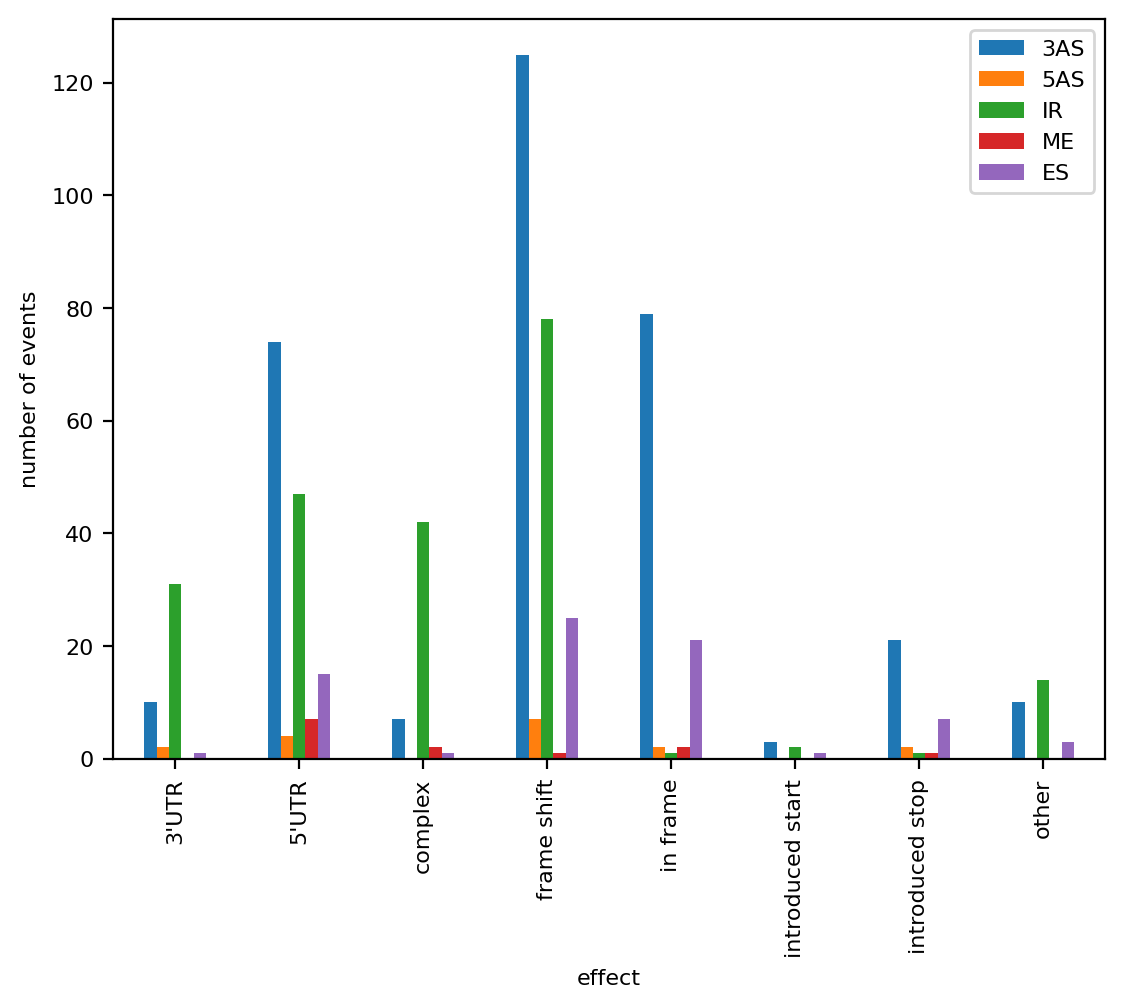

In [19]:
splicing=('3AS','5AS', 'IR','ME', 'ES')
n_effect={}
for st in splicing:
    n_effect[st]=res_sig[diff_cmp].query('splice_type == @st').value_counts('effect')
ax=pd.DataFrame(n_effect).plot.bar()
ax.set_ylabel('number of events')


In [20]:
df=[pd.DataFrame(d[i] for d in diff_effect['all']) for i in range(2)]
df2 = [np.zeros_like(d) for d in df]
for i in range(2):
    df2[i][np.arange(len(df[i])), df[i].values.argmax(1)] = 1
col=df[0].columns
res_sig[diff_cmp]['effect']=[(col[np.where(v1)][0],col[np.where(v2)][0]) for v1,v2 in zip(*df2)]  
#for k,v in zip(df.columns, df2.sum(0)):
#    print(f'{k}: \t{v}')# most "non coding" so far - may still change transcript distribution (DIE test)

In [21]:
# look for "poison exons"
# 1) look at domain plots for top ES examples (exclude UTR)pd.set_option('display.max_columns', 50)
columns=[c for c in res_sig[diff_cmp].columns if 'cov' not in c]

poison_exon_candidates=res_sig[diff_cmp].query('splice_type == "ES" and all_mut_PSI>all_wt_PSI and event_fraction>.5 and effect_complex != "100.00% in frame"')[columns]
poison_exon_candidates=poison_exon_candidates.loc[[not any(['UTR' in s for s in l]) for l in poison_exon_candidates.effect]] # did not manage to include this into query
poison_exon_candidates=poison_exon_candidates.loc[[not all(['in frame' == s for s in l]) for l in poison_exon_candidates.effect]] # did not manage to include this into query

# besides BRD9, TAF2
poison_exon_candidates
# for g in $(cut -d, -f1 /project/42/pacbio/golong/06-isotools/golong_all/results_2022_12/04_differential_splicing/tables/golong_all_2022_12_poison_exon_candidates_all.csv ); do  echo $(ls *${g}_ES_hmmer_utr.pdf); done

,gene,gene_id,chrom,strand,start,end,splice_type,novel,padj,pvalue,...,nmdDiff,all_mut_PSI,all_mut_disp,all_wt_PSI,all_wt_disp,total_PSI,total_disp,event_fraction,effect,effect_complex
77,TAF2,ENSG00000064313.12,chr8,-,119793451,119795531,ES,True,0.000001,1.399339e-09,...,0.171001,0.195352,0.024210,0.027309,4.094199e-07,0.104673,0.013795,0.794165,"(frame shift, other)",100.00% frame shift
106,BRD9,ENSG00000028310.18,chr5,-,865581,870472,ES,False,0.000009,1.129853e-08,...,0.929402,0.364454,0.024139,0.073793,1.671297e-03,0.221473,0.035087,0.959024,"(introduced stop, frame shift)",100.00% introduced stop
125,ARHGAP25,ENSG00000163219.12,chr2,+,68787956,68807272,ES,True,0.000019,2.976859e-08,...,0.019493,0.162384,0.012742,0.024466,3.721377e-04,0.094210,0.010474,0.698889,"(frame shift, other)",80.21% frame shift;19.79% 5'UTR
143,SLC25A13,ENSG00000004864.14,chr7,-,96193183,96208837,ES,True,0.000039,6.808994e-08,...,0.149804,0.220354,0.023094,0.012802,5.742489e-04,0.119870,0.027738,0.910152,"(frame shift, other)",97.69% frame shift
347,ATAD1,ENSG00000138138.13,chr10,-,87756922,87767672,ES,True,0.006359,2.698001e-05,...,0.785265,0.235404,0.019444,0.066698,4.167875e-03,0.145377,0.018728,0.916024,"(introduced stop, frame shift)",100.00% introduced stop
350,PELI1,ENSG00000197329.12,chr2,-,64100499,64104700,ES,False,0.006603,2.825759e-05,...,0.006171,0.107503,0.003138,0.047317,2.002935e-04,0.079875,0.002250,0.787869,"(frame shift, frame shift)",93.65% frame shift
357,GSAP,ENSG00000186088.16,chr7,-,77397415,77404558,ES,True,0.007418,3.243604e-05,...,0.038901,0.182497,0.011841,0.110005,2.072644e-05,0.123118,0.001215,0.897859,"(frame shift, other)",74.64% frame shift;25.36% 5'UTR
366,UBAP1,ENSG00000165006.14,chr9,+,34220948,34234215,ES,True,0.008089,3.619484e-05,...,0.015820,0.054612,0.001188,0.011019,1.075502e-04,0.033137,0.001061,0.875842,"(frame shift, other)",100.00% frame shift
461,UCHL5,ENSG00000116750.14,chr1,-,193029657,193049745,ES,True,0.022308,1.256597e-04,...,0.053674,0.134790,0.010353,0.027483,1.008482e-03,0.085362,0.008773,0.945119,"(frame shift, frame shift)",100.00% frame shift
492,STAU2,ENSG00000040341.18,chr8,-,73688813,73738283,ES,False,0.028636,1.721265e-04,...,0.002704,0.313527,0.013790,0.186197,1.842029e-03,0.252829,0.010594,0.930019,"(frame shift, frame shift)",98.31% frame shift


In [22]:
idx=77
group_fractionsB={}
group_fractionsA={}
for idx in poison_exon_candidates.index:
    g=isoseq[poison_exon_candidates.loc[idx,'gene']]
    #print(g.name)
    cov=g.coverage
    fracA=[]
    fracB=[]
    trA=poison_exon_candidates.loc[idx,'trA']
    trB=poison_exon_candidates.loc[idx,'trB']
    for grpn,grp in group_idx.items():
        fracA.append(cov[np.ix_(grp,trA)].sum()/cov[grp,].sum())
        fracB.append(cov[np.ix_(grp,trB)].sum()/cov[grp,].sum())
        #print(f'{grpn}: {fracB:.2%}')
    group_fractionsA[idx]=fracA
    group_fractionsB[idx]=fracB
#substantial_fraction.loc['TAF2']
group_fractionsB_df=pd.DataFrame.from_dict(group_fractionsB, orient='index', columns=[f'poisoned_fraction_{gn}' for gn in group_idx])
poison_exon_candidates=pd.concat([poison_exon_candidates,group_fractionsB_df], axis=1)
poison_exon_candidates.to_csv(f'{table_path}/{project}_{date}_poison_exon_candidates_{diff_cmp}.csv', index=False)


/scratch/local/ipykernel_41561/2405497732.py:13: RuntimeWarning: invalid value encountered in long_scalars
  fracA.append(cov[np.ix_(grp,trA)].sum()/cov[grp,].sum())
/scratch/local/ipykernel_41561/2405497732.py:14: RuntimeWarning: invalid value encountered in long_scalars
  fracB.append(cov[np.ix_(grp,trB)].sum()/cov[grp,].sum())


In [23]:
res_sig[diff_cmp].effect.astype(str)

0          ('frame shift', 'frame shift')
1                ('frame shift', 'other')
2                ('in frame', 'in frame')
3                ('in frame', 'in frame')
4                ('in frame', 'in frame')
                      ...                
777                    ("5'UTR", "5'UTR")
778    ('introduced stop', 'frame shift')
779              ("5'UTR", 'frame shift')
780                    ("5'UTR", "5'UTR")
781                    ("5'UTR", "5'UTR")
Name: effect, Length: 782, dtype: object

In [24]:
# the fraction of transcripts contributing less than 1% varies substantially between genes

substantial_fraction={}
for g in isoseq.iter_genes(min_coverage=100, progress_bar=True):
    substantial=g.filter_transcripts("SUBSTANTIAL")
    max_frac=g.coverage[:,np.argmax(g.coverage.sum(0))].sum()/g.coverage.sum()
    frac=g.coverage[:,substantial].sum()/g.coverage.sum()
    #print(f'{g.name} {frac:.2%}')
    substantial_fraction[g.name]=[max_frac,frac,g.coverage.sum(),len(g.transcripts)]
substantial_fraction=pd.DataFrame.from_dict(substantial_fraction,orient='index', columns=['max_fraction','substantial_fraction', 'total_cov', 'n_tr'])

100%|██████████| 149009/149009 [00:52<00:00, 2856.47genes/s]


<AxesSubplot: xlabel='substantial_fraction', ylabel='Count'>

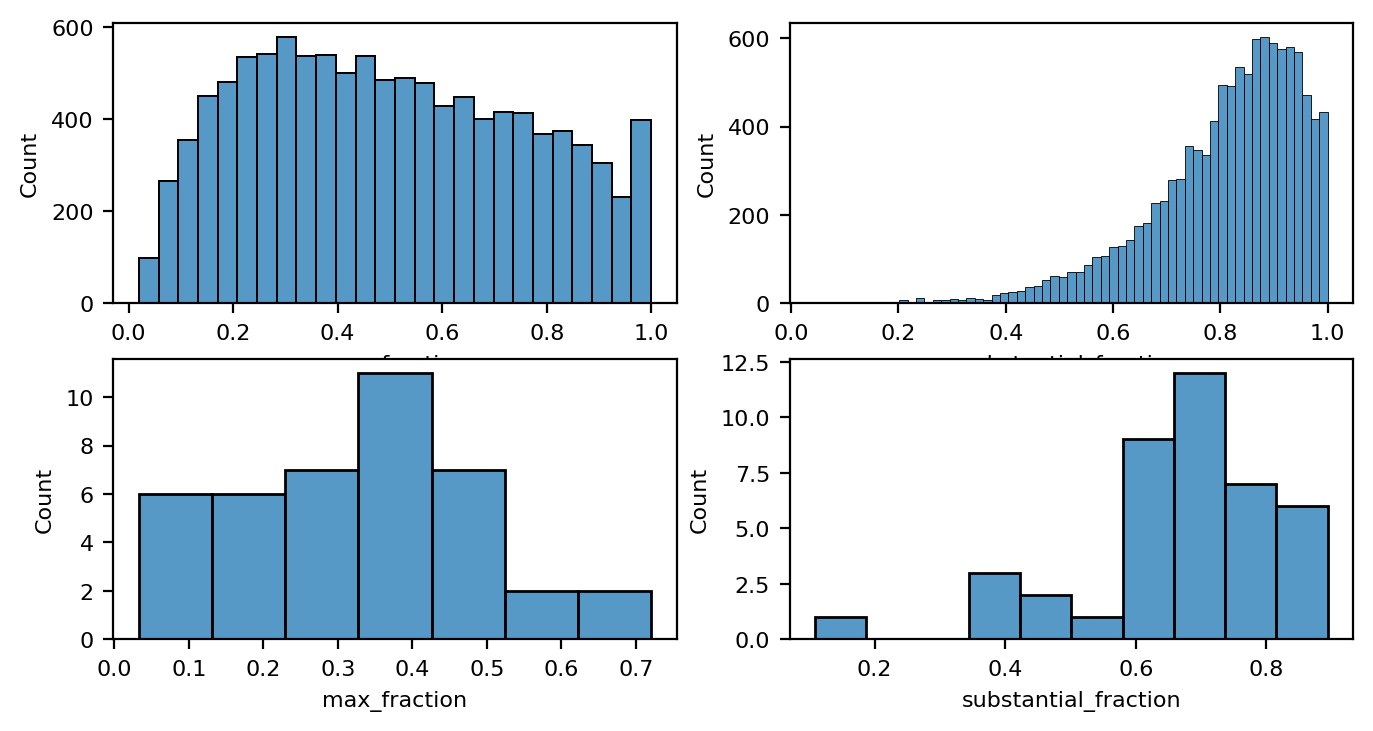

In [25]:
import seaborn as sns
poison_exon_genes=list(set(res_sig[diff_cmp].query('splice_type == "ES" and all_mut_PSI>all_wt_PSI').gene))

fig,axs=plt.subplots(2,2,figsize=(8,4))
sns.histplot(substantial_fraction,x='max_fraction',ax=axs[0,0])
sns.histplot(substantial_fraction.loc[poison_exon_genes],x='max_fraction',ax=axs[1,0])
sns.histplot(substantial_fraction,x='substantial_fraction',ax=axs[0,1])
sns.histplot(substantial_fraction.loc[poison_exon_genes],x='substantial_fraction',ax=axs[1,1])


### 2) impact on domains

#### A: Gain/Loss of protein domains
Idea: for each differential event, check the number/fraction of reads supporting each domain. Report the domains that have the greatest deviance between sets A and B. 

Results (target):
* nice examples(eg ZNF91 3AS mut prefered has 73.58% less KRAB box (PF01352.30))
* statistics: XXX % lead to partial loss of protein domains

#### B: Affected/Overlapping domains
Idea: even if a domain is not removed completely, a shortened/longer domain sequence might still has functional impact

#### C: Different structure
Idea: Different folding might rearrange domains, e.g. away from the protein surface, and theirby change their function. 

* This is difficult to show, but maybe alphafold can help. 
* How to select promising candidates?
    * interesting genes, that cannot be explained otherwise
    * "sharp turns" in the structure seem to be vulnerable
    * "overlapping functional elements" - e.g. alpha helix/ betasheets
    




In [85]:
diff_domain={}
for diff_cmp in ["all", "CL","CLL",'MDS']:
    diff_domain[diff_cmp]=[]
    groups_test[diff_cmp]
    sa=[i for  i,sn in enumerate(isoseq.samples) if sn in (gr[diff_cmp+'_wt']+gr[diff_cmp+'_mut'])]
    for idx,row in res_sig[diff_cmp].iterrows():
        g=isoseq[row.gene_id]        
        dom_counts={}
        dom_frac={}
        cov=g.coverage[sa,:].sum(0)
        substantial=g.filter_transcripts("SUBSTANTIAL")
        trA=[i for i in row.trA if i in substantial]
        trB=[i for i in row.trB if i in substantial]
        for ab,trset in enumerate((trA, trB)):
            for trid in trset:
                tr=g.transcripts[trid]
                dom_set={dom[0] for dom in tr.get('domain',{}).get('hmmer',[])}
                for dom in dom_set: #issue: non substantial transcripts are neglegted
                    dom_counts.setdefault(dom,[0,0])
                    dom_counts[dom][ab]+=cov[trid]
        for dom, dom_cov in dom_counts.items():
            dom_frac[dom]=(dom_cov[0]/cov[trA].sum(), dom_cov[1]/cov[trB].sum())
        diff_domain[diff_cmp].append(dom_frac)
        

/scratch/local/ipykernel_42156/2305164770.py:22: RuntimeWarning: invalid value encountered in long_scalars
  dom_frac[dom]=(dom_cov[0]/cov[trA].sum(), dom_cov[1]/cov[trB].sum())


In [86]:
from isotools.domains import parse_hmmer_metadata
pfam=parse_hmmer_metadata(f'{path}/../references/Pfam/Pfam-A.hmm.dat.gz')

In [87]:
diff_cmp='all'
th=.25
for diff_cmp in diff_domain:
    c=0
    print(diff_cmp)
    for i,dom in enumerate(diff_domain[diff_cmp]):
        for dom_id, frac in dom.items():
            if abs(frac[0]-frac[1])>th:
                res_row=res_sig[diff_cmp].iloc[i]
                delta=frac[0]-frac[1]
                if res_row[diff_cmp+'_mut_PSI']>res_row[diff_cmp+'_wt_PSI']:
                    delta*=-1
                print(f'{i}: {res_row["gene"]} {res_row["splice_type"]} mut prefered has {abs(delta):.2%} {"more" if delta>0 else "less"} {pfam.loc[dom_id, "DE"]} ({dom_id})')
                c+=1
        if c>100:
            break

all
0: SEPTIN6 3AS mut prefered has 100.00% less Protein of unknown function (DUF763) (PF05559.14)
0: SEPTIN6 3AS mut prefered has 100.00% more AAA domain (PF13086.9)
1: MAP3K7 3AS mut prefered has 100.00% more Seryl-tRNA synthetase N-terminal domain (PF02403.25)
1: MAP3K7 3AS mut prefered has 100.00% more Protein of unknown function (DUF1778) (PF08681.14)
9: ANKHD1 3AS mut prefered has 60.32% more Rnk N-terminus (PF14760.9)
9: ANKHD1 3AS mut prefered has 47.61% less Type VI secretion, EvfE, EvfF, ImpA, BimE, VC_A0119, VasJ (PF16989.8)
10: DLST 3AS mut prefered has 34.68% less Glycine cleavage H-protein (PF01597.22)
14: ZNF91 3AS mut prefered has 100.00% less KRAB box (PF01352.30)
15: SLC3A2 3AS mut prefered has 25.93% more Maltogenic Amylase, C-terminal domain (PF16657.8)
16: CEP135 3AS mut prefered has 100.00% less Domain of unknown function (DUF4248) (PF14053.9)
16: CEP135 3AS mut prefered has 70.00% less Autophagy protein 16 (ATG16) (PF08614.14)
16: CEP135 3AS mut prefered has 87.9